## Libraries to be imported

In [24]:
#from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from keras.layers import Dense, Input, regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import lightgbm as lgb
import seaborn as sns
from subprocess import call
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

## Unzip the train file

## Reading  data

In [2]:
train = pd.read_csv('gs://bucket_sepsis/train.psv', sep = "|")
val = pd.read_csv('gs://bucket_sepsis/validation.psv', sep = '|')

## Feature Engineering

### Heart Rate

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing

In [3]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
    train['custom_hr'].fillna('Missing', inplace=True)
    return train

### Temperature

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C.  Creating a new feature custom_temp , which is categorical variable having three values Normal, Abnormal and Missing

In [4]:
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

    train['custom_temp'].fillna('Missing', inplace=True)
    return train


### Age

Categorizing patient based on age to old, infant and Child/adult

In [5]:
def featuer_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <1, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'custom_age'] = 'child/adult'
    return train

### O2Stat

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [6]:
def feature_engineer_o2stat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

    train['custom_o2stat'].fillna('Missing', inplace=True)
    return train


### SBP and DBP

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [7]:
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

    train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'custom_bp'] = 'normal'


    train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'custom_bp'] = 'elevated'


    train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

    train['custom_bp'].fillna('Missing', inplace=True)
    return train

### Respiration Rate

Respiration rate for healthy adults is between 12 and 20.  Categorizing respiratory rate as normal and abnormal based on thresholds.

In [8]:
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'custom_resp'] = 'abnormal'

    train['custom_resp'].fillna('Missing', inplace=True)


    return train
  

## Transform Train and Validation sets

In [9]:
train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)



val = featuer_engineer_age(val)
val = feature_engineer_blood_pressure(val)
val = feature_engineer_hr(val)
val = feature_engineer_o2stat(val)
val = feature_engineer_temp(val)
val = feature_engineer_resp_rate(val)




## Intution Based Feature Selection

According to the CDC website heart rate, fever and BP are the most important signs of sepsis. So selecting these features with the same intution

In [10]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [11]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

## Defining the Pipeline

In [12]:
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))


## Custom Score function

In [13]:
def score_model(model, metric_list, y_true, y_pred):
    metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix, 
                 'avg_precision': average_precision_score}
    df = pd.DataFrame()
    df['model'] = [model]
    for metric in metric_list:
        df[metric] = [metric_dict[metric](y_true, y_pred)]
    return df

# Logistic Regression

## Training Model

In [32]:
log_pipe_scale = make_pipeline(preprocess_trans_scale, 
                               LogisticRegression(C=0.01, solver = 'lbfgs',
                                                  dual=False) )

log_model = log_pipe_scale.fit(X_train, y_train)

## Prediction and Scoring

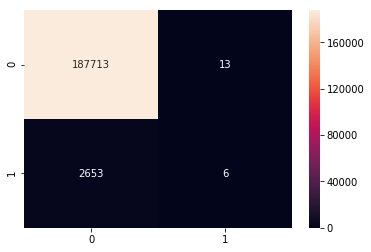

In [33]:
pred = log_pipe_scale.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [34]:
score_model('Logistic_regression', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Logistic_regression,0.002256,0.315789,0.014647


## Defining Custom Threshold

In [35]:
df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

df['actual'] = y_val
df.loc[(df[1] >=0.4), 'pred'] = 1 
df.loc[(df[1] <0.4), 'pred'] = 0 

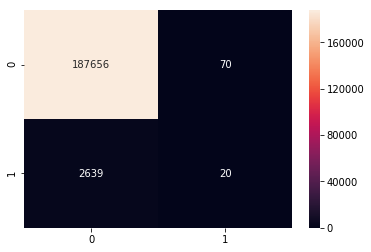

In [36]:
conf_matrix = confusion_matrix(df['actual'], df['pred'])

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [37]:
score_model('Logistic_regression', ['recall','precision','avg_precision'], 
            df['actual'], df['pred'])

,model,recall,precision,avg_precision
0,Logistic_regression,0.007522,0.222222,0.015533


In [38]:
eval_df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

eval_df['actual'] = y_val

def eval_threshold(eval_df, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        eval_df.loc[(eval_df[1] >=threshold), 'pred'] = 1 
        eval_df.loc[(eval_df[1] <threshold), 'pred'] = 0 
        avg_pre_list.append(average_precision_score(eval_df['actual'], 
                                                    eval_df['pred']))
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(eval_df, list(np.arange(0,1,0.05)))
  
  

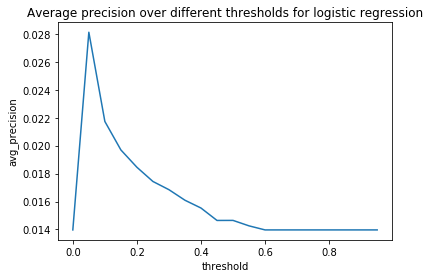

In [39]:
ax=sns.lineplot(comp['threshold'], comp['avg_precision'])
_=ax.set_title('Average precision over different thresholds for logistic regression')

## Grid Search

In [40]:
param_grid = {'logisticregression__C': [0.1, 0.01, 0.5, 1],
             'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 
                                           'sag', 'saga']}
grid = GridSearchCV(log_pipe_scale, param_grid, cv=3, scoring = 'average_precision', n_jobs = 6)
grid.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [41]:
print(grid.best_params_)

{'logisticregression__solver': 'lbfgs', 'logisticregression__C': 0.01}


# Decision Tree

## Training the Model

In [43]:
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier() )

dt_model = dt_pipe_scale.fit(X_train, y_train)

## Prediction and Scoring

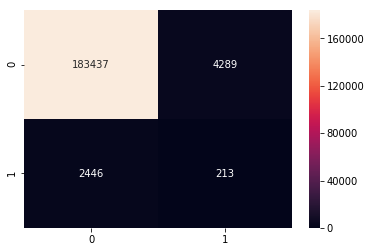

In [44]:
pred = dt_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [45]:
score_model('Decision_Tree', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Decision_Tree,0.080105,0.047312,0.016638


## Display D-Tree

In [46]:
cat_names = preprocess_trans_scale.fit(X_train). \
            named_transformers_['pipeline-2'].named_steps['onehotencoder']

feature_list = list(cat_names.get_feature_names())
feature_list.extend(['ICULOS', 
                    'HospAdmTime'])


export_graphviz(DecisionTreeClassifier(max_leaf_nodes=15).fit( \
    preprocess_trans_scale.fit_transform(X_train), y_train) , 
                out_file='dt.dot',
                feature_names =feature_list ,class_names = ['normal','sepsis'],
                rounded = True, proportion = False, precision = 2
               )
call(['dot', '-Tpng', 'dt.dot', '-o', 'dt.png', '-Gdpi=600'])

Image(filename = 'dt.png', width =400, height = 400)


## Grid Search

In [47]:
param_grid = { 'decisiontreeclassifier__max_depth': range(1, 7),
                'decisiontreeclassifier__max_leaf_nodes':range(2, 20)}
grid = GridSearchCV(dt_pipe_scale, param_grid, cv=3, n_jobs = 6, scoring= 'recall')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [48]:
print(grid.best_params_)

{'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_leaf_nodes': 17}


In [34]:
imp_list = dt_model.named_steps['decisiontreeclassifier'].feature_importances_

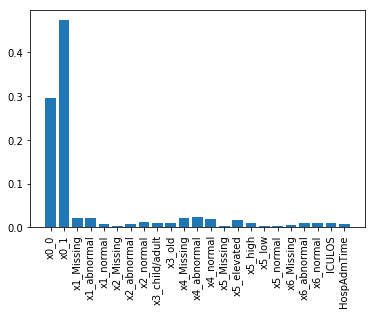

In [35]:
_ = plt.bar(feature_list,imp_list)
_ = plt.xticks(feature_list, rotation=90)

In [36]:
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier(max_depth=6, max_leaf_nodes=17) )

dt_model = dt_pipe_scale.fit(X_train, y_train)

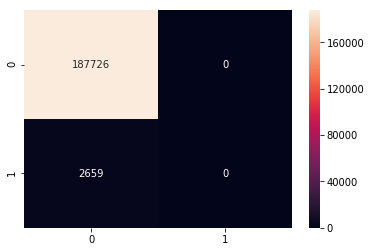

In [37]:
pred = dt_pipe_scale.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

# Gradient Boosting

## Training the Model

In [49]:
gb_pipe_scale = make_pipeline(preprocess_trans_scale, GradientBoostingClassifier(n_estimators=50))

gb_model = gb_pipe_scale.fit(X_train, y_train)


## Prediction and Scoring

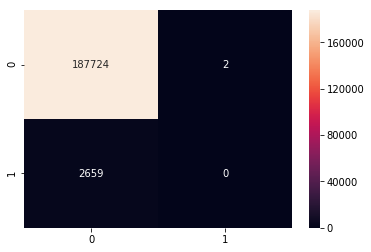

In [50]:
pred = gb_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [41]:
score_model('Gradient Boosting', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Gradient Boosting,0.0,0.0,0.013966


## Grid Search

In [51]:
param_grid = {'gradientboostingclassifier__learning_rate': [0.1,0.01, 0.001, 0.25],
                'gradientboostingclassifier__n_estimators': [10,50,100,150]}
grid = GridSearchCV(gb_pipe_scale, param_grid, cv=3, n_jobs = 6, scoring= 'average_precision')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [52]:
grid.best_params_

{'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__n_estimators': 50}

# Random Forest

## Train the Model

In [53]:
rf_pipe_scale = make_pipeline(preprocess_trans_scale, RandomForestClassifier(max_features='sqrt', n_estimators=150))

rf_model = rf_pipe_scale.fit(X_train, y_train)

## Prediction and Scoring

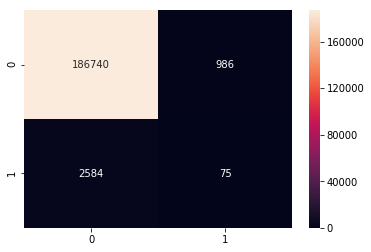

In [54]:
pred = rf_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [55]:
score_model('Random Forest', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Random Forest,0.028206,0.070688,0.015566


## Grid Search

In [56]:
param_grid = {'randomforestclassifier__max_features': ['auto','sqrt','log2'],
                'randomforestclassifier__n_estimators': [10,50,100,150]}
grid = GridSearchCV(rf_pipe_scale, param_grid, cv=3, n_jobs = 6, scoring= 'average_precision')
grid.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [57]:
grid.best_params_

{'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__n_estimators': 150}

# LightGBM

## Train the Model

In [58]:
X_train_transformed = preprocess_trans_scale.fit_transform(X_train)

d_train = lgb.Dataset(X_train_transformed, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10
clf = lgb.train(params, d_train, 100)

## Prediction and Scoring

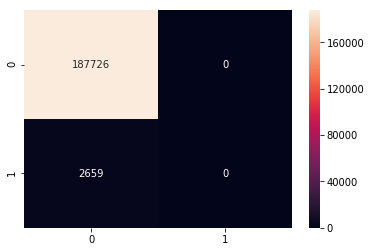

In [59]:
pred = clf.predict(preprocess_trans_scale.transform(X_val))
pred[pred <0.5] = 0
pred[pred >=0.5] = 1

conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [61]:
score_model('Light GBM', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Light GBM,0.0,0.0,0.013966


## Custom Thresholds

In [38]:
pred = clf.predict(preprocess_trans_scale.transform(X_val))


def eval_threshold(pred, y_val, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        pred[pred <threshold] = 0
        pred[pred >=threshold] = 1
        avg_pre_list.append(average_precision_score(y_val, 
                                                    pred))
    
    
    
    
    
    
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(pred,y_val, list(np.arange(0,1,0.05)))
  
  

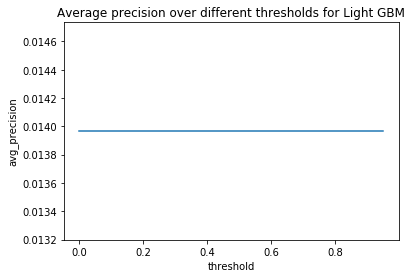

In [41]:
ax=sns.lineplot(comp['threshold'], comp['avg_precision'])
_=ax.set_title('Average precision over different thresholds for Light GBM')

# AutoEncoders

## Filter data on class labels (0 and 1)

In [14]:
train_0 = train[train['SepsisLabel'] ==0]
train_1 = train[train['SepsisLabel'] ==1]

filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train_0  = train_0[filtered_columns]
y_train_0 = train_0['SepsisLabel']

## Fit/Transform data 

In [20]:
X_train_0_transformed = preprocess_trans_scale.fit_transform(X_train_0)

X_val_transformed = preprocess_trans_scale.transform(X_val)

## Defining the AutoEncoder Architecture

In [62]:
nb_epoch = 200
batch_size = 128
input_dim = X_train_0_transformed.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                768       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_10 (Dense)             (None, 23)                759       
Total params: 2,871
Trainable params: 2,871
Non-trainable params: 0
_________________________________________________________________


## Training AutoEncoder

In [63]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=25)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_0_transformed, X_train_0_transformed,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1,
                    callbacks=[cp, tb, es]).history

Epoch 1/200
1147309/1147309 [==============================] - 21s 19us/step - loss: 0.1049 - acc: 0.0672
Epoch 2/200
   5376/1147309 [..............................] - ETA: 36s - loss: 0.0717 - acc: 0.0999

/home/jupyter/.local/lib/python3.5/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1147309/1147309 [==============================] - 22s 19us/step - loss: 0.0645 - acc: 0.1250
Epoch 3/200
1147309/1147309 [==============================] - 22s 19us/step - loss: 0.0568 - acc: 0.1528
Epoch 4/200
1147309/1147309 [==============================] - 21s 18us/step - loss: 0.0545 - acc: 0.1691
Epoch 5/200
1147309/1147309 [==============================] - 20s 18us/step - loss: 0.0520 - acc: 0.1555
Epoch 6/200
1147309/1147309 [==============================] - 20s 17us/step - loss: 0.0505 - acc: 0.1568
Epoch 7/200
1147309/1147309 [==============================] - 20s 18us/step - loss: 0.0498 - acc: 0.1564
Epoch 8/200
1147309/1147309 [==============================] - 21s 18us/step - loss: 0.0492 - acc: 0.1561
Epoch 9/200
1147309/1147309 [==============================] - 21s 18us/step - loss: 0.0493 - acc: 0.1526
Epoch 10/200
1147309/1147309 [==============================] - 21s 18us/step - loss: 0.0489 - acc: 0.1503
Epoch 11/200
1147309/1147309 [===========================

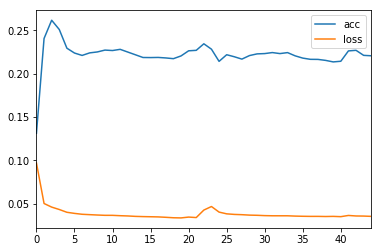

In [19]:
pd.DataFrame(history).plot()

## Define Threshold using Precision/Recall Curve

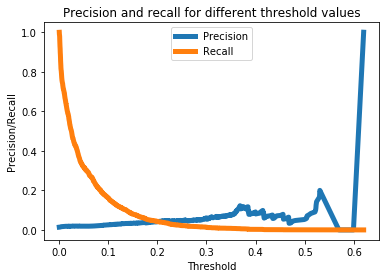

In [25]:
valid_x_predictions = autoencoder.predict(X_val_transformed)
mse = np.mean(np.power(X_val_transformed - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

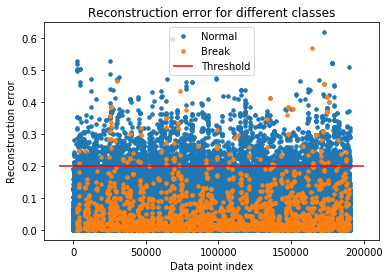

In [28]:
valid_x_predictions = autoencoder.predict(X_val_transformed)
mse = np.mean(np.power(X_val_transformed - valid_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.2
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

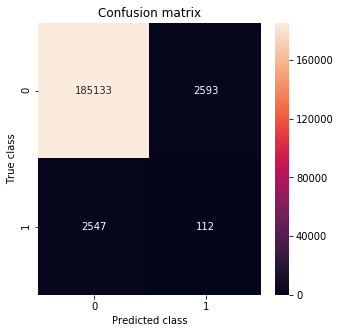

In [31]:
LABELS = ["Normal","Sepsis"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()